In [63]:
# -*- coding: utf-8 -*-

import numpy as np
from collections import OrderedDict
#import argparse
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import os

GFF_File = '/Users/sidhug/Desktop/Haplotype_project/large_datasets/Brassica_napus.AST_PRJEB5043_v1.44.sorted.gff3'
VCF_FILE = '/Users/sidhug/Desktop/Haplotype_project/large_datasets/raw.g5mac3dplm.recode.vcf'
SAMPLE_NAMES_FILE = '/Users/sidhug/Desktop/Haplotype_project/large_datasets/sample_names.txt'

#GENE_TO_LOOK = ['BnaA02g00370D', 'BnaA03g02820D', 'BnaA03g13630D', 'BnaA10g22080D', 'BnaC02g00490D', 'BnaC03g04170D', 'BnaC03g16530D', 'BnaC09g46500D', 'BnaC09g46540D', 'BnaA02g06490D', 'BnaA04g15260D', 'BnaC04g53290D', 'BnaC04g53290D', 'BnaC04g53290D', 'BnaA05g05010D', 'BnaCnng45490D', 'BnaAnng19140D', 'BnaA03g37880D', 'BnaA03g39820D', 'BnaA06g24000D', 'BnaA04g13710D']
GENE_TO_LOOK = ['BnaC03g01440D']

def gff_parse(gff_file, genes_to_look):
    
    Genes = {}
    genes_found = 0
    with open(gff_file, "r") as in_f:
        line = in_f.readline()
        while line:
            line = line.rstrip('\n')
            if line.startswith('#') != True:
                contig = line.split('\t')[0]
                locus_type = line.split('\t')[2]
                if locus_type ==  'gene':
                    gene_name = line.split("\t")[8].split(";")[1].lstrip('Name=')
                    if gene_name in genes_to_look:
                        if contig not in Genes.keys():
                            Genes[contig] = {}
                        (start_pos, stop_pos) = (line.split("\t")[3], line.split("\t")[4])
                        Genes[contig][gene_name] = (start_pos, stop_pos)
                        genes_found += 1
            line = in_f.readline()
    
    return Genes, genes_found


def vcf_parse(vcf_file, Genes):
    # complete_allele_patterns: {SLXXXX:{LKXXXX:{'0001','10101'}, LKXX:..}, SLXX..}
    complete_allele_patterns = {}
    # super_contigs: { LKXXXX: OrderedDict{POS1: (ref, alt), POS2: (ref, alt)..}, LKXXX..}
    #order of posttion values in dict is crucial for this - so LKXXX dicts are all ordered.  
    super_contigs = {}

    with open(vcf_file, 'r') as in_f:
        line = in_f.readline()
        while line:
            line = line.rstrip('\n')
            if line.startswith('#CHROM'):
                samples = line.split('\t')[9:]
                print("Reading the {} file, {} samples found.".format(vcf_file, len(samples)))
                for indv in samples:
                    complete_allele_patterns[indv] = {}
            if line.startswith("#") != True:
                locus = line.split('\t')[0]
                if locus in list(Genes.keys()):
                    super_contigs[locus] = OrderedDict()
                    for indv in complete_allele_patterns.keys():
                        complete_allele_patterns[indv][locus] = ['','']
            line = in_f.readline()

    with open(vcf_file, 'r') as in_f:
        line = in_f.readline()
        while line:
            line = line.rstrip('\n')
            if line.startswith('#') != True:
                line_array = line.split('\t')
                locus = line_array[0]
                position = line_array[1]
                ref = line_array[3]
                alt = line_array[4]
                variant_type = line_array[7].split(';')[-1].lstrip('TYPE=')
                if locus in Genes.keys():
                    super_contigs[locus][position] = (position, variant_type, ref, alt)
                    
                    #for genotype
                    all_samples_genotypes = []
                    for data in line_array[9:]:
                        G = data.split(':')[0]
                        if G == ".":
                            all_samples_genotypes.append("./.")        
                        else:
                            all_samples_genotypes.append(G)
                    
                    assert len(all_samples_genotypes) == len(complete_allele_patterns.keys())
                    for i in range(len(all_samples_genotypes)):
                        
                        complete_allele_patterns[list(complete_allele_patterns.keys())[i]][locus][0] = complete_allele_patterns[list(complete_allele_patterns.keys())[i]][locus][0] + all_samples_genotypes[i].split("/")[0]
                        complete_allele_patterns[list(complete_allele_patterns.keys())[i]][locus][1] = complete_allele_patterns[list(complete_allele_patterns.keys())[i]][locus][1] + all_samples_genotypes[i].split("/")[1]
                        #else:
                        #    print("ERROR in Genotype representation for {}:{} {}".format(locus, position, all_samples_genotypes[i]))
            line = in_f.readline()


    return complete_allele_patterns, super_contigs


def alleles_slicer(start_stop, allele_seqs, positions, gene, locus, sample):
        
    """
        Takes whole contig allele sequences and outputs sliced sequences.
        
        input:
            start_stop: a tuple of ints 
            allele_seqs: a tuple of two alleles patterns. a array/tuple of strings.
            positions: a list of positions for every allele in haplotype sequence.
        
        returns:
            a tupple of sliced allele seqs
    """
    
    try:
        assert len(allele_seqs[0]) == len(positions)
        assert len(allele_seqs[0]) == len(allele_seqs[1])
    except:
        AssertionError
        print("Lengths of position array {} and both allele strings {},{} do not match. {}:{}:{}".format(len(positions),len(allele_seqs[0]), len(allele_seqs[1]), gene,locus,sample))
    pos_array = []
    sliced_allele_0 = ''
    sliced_allele_1 = ''
    for i in range(len(positions)):
        if int(positions[i]) >= int(start_stop[0]) and int(positions[i]) <= int(start_stop[1]):
            pos_array.append(positions[i])
            sliced_allele_0 = sliced_allele_0 + allele_seqs[0][i]    
            sliced_allele_1 = sliced_allele_1 + allele_seqs[1][i]
    
    return (pos_array, [sliced_allele_0, sliced_allele_1])


def final_haplotype_pruning(Genes, complete_allele_patterns ,super_contigs):

    final_data = {}
    for super_locus in super_contigs.keys():
        super_locus_dict = {}
        position_array = list(super_contigs[super_locus].keys())
        for gene in Genes[super_locus].keys():
            current_gene_dict = {}
            start_stop = Genes[super_locus][gene]
            for sample in complete_allele_patterns.keys():
                current_gene_dict[sample] = {} #fill in the innermost dict first
                
                raw_allele_seqs = complete_allele_patterns[sample][super_locus]
                pos_array, sliced_allele_seqs = alleles_slicer(start_stop, raw_allele_seqs, position_array, gene, super_locus, sample)
                
                #marker format : Locus:POS:var_type:Ref allele:alt_allele1,alt_allele2
                marker_array = [super_locus+':'+pos+':'+super_contigs[super_locus][pos][1]+':'+super_contigs[super_locus][pos][2] + ':'+super_contigs[super_locus][pos][3] for pos in pos_array]
                current_gene_dict[sample] = [marker_array, sliced_allele_seqs[0], sliced_allele_seqs[1]]
            final_data[gene] = current_gene_dict

    return final_data


def distance_calculator(seqA_array, seqB_array):
    """
    Return distance between two loci based on two set of allele patterns

    Parameters
    ----------
    seqA_array : List of two strings
        eg. ['101001', '101101']
    seqB_array : List of two strings
        eg. ['101001', '101101']
        

    Returns
    -------
    float
        distance between two samples, averaged. 
        Scoring scheme: +1 if both allele patterns differ
                        +0.5 if only one is different 
                         
    """
    try:
        assert len(seqA_array[0]) == len(seqB_array[0])
        assert len(seqA_array[1]) == len(seqB_array[1])
    except:
        AssertionError
        print("Sequence length mismatch.")
    pattern0 = zip(seqA_array[0], seqB_array[0])
    difference0 = sum([1 for allele in pattern0 if allele[0] != allele[1]])
    pattern1 = zip(seqA_array[1], seqB_array[1])
    difference1 = sum([1 for allele in pattern1 if allele[0] != allele[1]])

    return (difference0 + difference1)/2




def distance_calculator_eu(seqA_array, seqB_array, NA='5'):
    """
    Return distance between two loci based on two set of allele patterns

    Parameters
    ----------
    seqA_array : List of two strings
        eg. ['101001', '101101']
    seqB_array : List of two strings
        eg. ['101001', '101101']
        

    Returns
    -------
    float
        distance between two samples, averaged. 
        Scoring scheme: +1 if both allele patterns differ
                        +0.5 if only one is different 
                         
    """
    try:
        assert len(seqA_array[0]) == len(seqB_array[0])
        assert len(seqA_array[1]) == len(seqB_array[1])
    except:
        AssertionError
        print("Sequence length mismatch.")

    for i, seq in enumerate(seqA_array):
        seqA_array = seq.replace('.', NA)
    for i, seq in enumerate(seqB_array):
        seqB_array = seq.replace('.', NA)

    vectorA_1 = np.array([int(i) for i in seqA_array[0]], dtype=int)
    vectorA_2 = np.array([int(i) for i in seqA_array[1]], dtype=int)

    vectorB_1 = np.array([int(i) for i in seqB_array[0]], dtype=int)
    vectorB_2 = np.array([int(i) for i in seqB_array[1]], dtype=int)
    
    eu_dist_1 = int(np.sqrt(np.sum(np.square(vectorA_1 - vectorB_1))))
    eu_dist_2 = int(np.sqrt(np.sum(np.square(vectorA_2 - vectorB_2))))
    
    return eu_dist_1 + eu_dist_2


def distance_calculator_ref(seqA_array):
    
    for i, seq in enumerate(seqA_array):
        seqA_array[i] = seq.replace('.', '0')
        
    vectorA_1 = np.array([int(i) for i in seqA_array[0]], dtype=int)
    vectorA_2 = np.array([int(i) for i in seqA_array[1]], dtype=int)
    
    return [vectorA_1.sum() , vectorA_2.sum()]


def supplementary_output(final_data, gene, sample_names_dict, output_file_name = None):
    if output_file_name == None:
        output_file_name = gene+"_haps.csv"
    else:
        output_file_name = os.path.join(output_file_name, gene+"_haps.csv")
        
    with open(output_file_name, "w") as out_f:
        #first line
        contig_line = " , ," + ','.join([s.split(":")[0] for s in final_data[gene][list(final_data[gene].keys())[0]][0]]) + "\n"
        zeroth_line = "POS, ,"+ ','.join([s.split(":")[1] for s in final_data[gene][list(final_data[gene].keys())[0]][0]]) + "\n"
        first_line = 'TYPE, ,'+ ','.join([s.split(":")[2].replace(',',';') for s in final_data[gene][list(final_data[gene].keys())[0]][0]]) + "\n"
        second_line = 'REF, ,'+ ','.join([s.split(":")[3] for s in final_data[gene][list(final_data[gene].keys())[0]][0]]) + "\n\n"
        out_f.write(contig_line+zeroth_line+first_line+second_line)
        for sample in final_data[gene]:
            haplotype1 = final_data[gene][sample][1]
            haplotype2 = final_data[gene][sample][2]
            seq1 = []
            seq2 = []
            for i in range(len(haplotype1)):
                ref = [final_data[gene][sample][0][i].split(':')[3]]
                alt = final_data[gene][sample][0][i].split(':')[4].split(",")
                ref_alt = ref + alt
                    
                if haplotype1[i] != '.' and haplotype2[i] != '.':
                    seq1.append(ref_alt[int(haplotype1[i])]) if int(haplotype1[i]) != 0 else seq1.append('*')
                    if haplotype1[i] == haplotype2[i]:
                        seq2.append('-')
                    else:
                        seq2.append(ref_alt[int(haplotype2[i])]) if int(haplotype2[i]) != 0 else seq2.append('*')
                        
                else:
                    if haplotype1[i] == '.':
                        seq1.append('.')
                        if haplotype2[i] == '.':
                            seq2.append('.')
                        else:
                            seq2.append(ref_alt[int(haplotype2[i])]) if int(haplotype2[i]) != 0 else seq2.append('*')
                    else:
                        seq1.append(ref_alt[int(haplotype1[i])]) if int(haplotype1[i]) != 0 else seq1.append('*')
                        if haplotype2[i] == '.':
                            seq2.append('.')
                        else:
                            seq2.append(ref_alt[int(haplotype2[i])]) if int(haplotype2[i]) != 0 else seq2.append('*')
            
            sample_line = sample_names_dict[sample]+","+ sample+","+','.join(seq1)+"\n"+' , '+','+','.join(seq2)+"\n\n"
            
            out_f.write(sample_line)        
                    
def create_dendrogram(linkage_matrix, gene, sample_line_names, output_file_name=None):
    
    if output_file_name == None:
        output_file_name = gene+".jpg"
    else:
        output_file_name = os.path.join(output_file_name, gene+".jpg")
        
    
    plt.figure(figsize=(15,7))
    plt.box(False)
    dendrogram(linkage_matrix, labels=sample_line_names)
    plt.yticks(np.arange(0,max(plt.yticks()[0]), 1))                    
    plt.grid(color='lightgrey', which='major', axis='y', linestyle='-')
    plt.title(gene)
    plt.savefig(output_file_name, dpi=300)
    
def output_allele_patterns(final_data, gene, sample_names_dict, output_file_name=None):
    if output_file_name == None:
        output_file_name = gene+"_patterns.txt"
    else:
        output_file_name = os.path.join(output_file_name, gene+"_patterns.txt")

    with open(output_file_name, 'w') as out_f:
        for sample in final_data[gene]:
            haplotype1 = final_data[gene][sample][1]
            haplotype2 = final_data[gene][sample][2]

            to_write = sample_names_dict[sample] + ":" +' '*(30-len(sample_names_dict[sample] + ":")) + final_data[gene][sample][1] +"\n"+ ' '*30+ final_data[gene][sample][2] +"\n" + "\n"
            out_f.write(to_write)


    
def main():
    Genes, num_genes_found = gff_parse(GFF_File, GENE_TO_LOOK)
    print("File successfully read, {} out of {} genes found.".format(num_genes_found, len(GENE_TO_LOOK)))
    complete_haplotypes, variant_data = vcf_parse(VCF_FILE, Genes)
    print("Data from VCF file loaded.")
    final_data = final_haplotype_pruning(Genes, complete_haplotypes, variant_data)

    samples = list(final_data[GENE_TO_LOOK[0]].keys())
    with open(SAMPLE_NAMES_FILE, "r") as in_f:
            lines = in_f.readlines()

    sample_names_dict = {}
    for line in lines[1:]:
        sample_names_dict[line.split("\t")[0]] = line.split("\t")[1].replace("\n",'')
    sample_line_names = [sample_names_dict[s] for s in samples]
    
    for bna_gene in final_data.keys():
        print("Working on {}".format(bna_gene))
        samples = list(final_data[bna_gene].keys())
        Distance_Matrix = np.zeros((len(samples), len(samples)))

        for vertical in range(Distance_Matrix.shape[0]):
            for horizontal in range(Distance_Matrix.shape[1]):
                Distance_Matrix[vertical][horizontal] = distance_calculator_eu(final_data[bna_gene][samples[vertical]][1:],final_data[bna_gene][samples[horizontal]][1:])

        dists = squareform(Distance_Matrix)
        linkage_matrix = linkage(dists, 'single')
        
        
        
        if 'Haplotypes' not in os.listdir():
            os.mkdir('Haplotypes')
        if bna_gene not in os.listdir('Haplotypes'):
            os.mkdir(os.path.join('Haplotypes', bna_gene))
            
        supplementary_output(final_data, bna_gene,sample_names_dict, os.path.join('Haplotypes', bna_gene))
        create_dendrogram(linkage_matrix, bna_gene, sample_line_names, os.path.join('Haplotypes', bna_gene))
        output_allele_patterns(final_data, bna_gene,sample_names_dict, os.path.join('Haplotypes', bna_gene))
        print("Finished gene {}\n".format(bna_gene))
        
    print("Dendrograms created. Provide the desired cut off values.\n")
    #input("Program paused. Press any key to continue..")
        
        
        
    #return final_data, Genes, linkage_matrix, sample_line_names, Distance_Matrix

#if __name__ == '__main__':
#    main()




In [64]:
def main():
    Genes, num_genes_found = gff_parse(GFF_File, GENE_TO_LOOK)
    print("File successfully read, {} out of {} genes found.".format(num_genes_found, len(GENE_TO_LOOK)))
    complete_haplotypes, variant_data = vcf_parse(VCF_FILE, Genes)
    print("Data from VCF file loaded.")
    final_data = final_haplotype_pruning(Genes, complete_haplotypes, variant_data)

    samples = list(final_data[GENE_TO_LOOK[0]].keys())
    with open(SAMPLE_NAMES_FILE, "r") as in_f:
            lines = in_f.readlines()

    sample_names_dict = {}
    for line in lines[1:]:
        sample_names_dict[line.split("\t")[0]] = line.split("\t")[1].replace("\n",'')
    sample_line_names = [sample_names_dict[s] for s in samples]
    
    for bna_gene in final_data.keys():
        print("Working on {}".format(bna_gene))
        samples = list(final_data[bna_gene].keys())
        #Distance_Matrix = np.zeros(len(samples))
        gene_dict = {}
        for i in range(len(samples)):
            haplotypes = final_data[bna_gene][samples[i]][1:]
            gene_dict[sample_names_dict[samples[i]]] = distance_calculator_ref(haplotypes)
            #print(sample_names_dict[samples[i]], str(distance_calculator_ref(haplotypes)))
            #Distance_Matrix[i] = distance_calculator_ref(haplotypes)
   
            

        
        
        if 'Haplotypes' not in os.listdir():
            os.mkdir('Haplotypes')
        if bna_gene not in os.listdir('Haplotypes'):
            os.mkdir(os.path.join('Haplotypes', bna_gene))
            
        #supplementary_output(final_data, bna_gene,sample_names_dict, os.path.join('Haplotypes', bna_gene))
        #create_dendrogram(linkage_matrix, bna_gene, sample_line_names, os.path.join('Haplotypes', bna_gene))
        output_allele_patterns(final_data, bna_gene,sample_names_dict, os.path.join('Haplotypes', bna_gene))
        print("Finished gene {}\n".format(bna_gene))
        
    #print("Dendrograms created. Provide the desired cut off values.\n")
    return gene_dict, final_data

In [65]:
D, F = main()

File successfully read, 1 out of 1 genes found.
Reading the /Users/sidhug/Desktop/Haplotype_project/large_datasets/raw.g5mac3dplm.recode.vcf file, 92 samples found.
Data from VCF file loaded.
Working on BnaC03g01440D
Finished gene BnaC03g01440D



In [54]:
from sklearn.cluster import AffinityPropagation

In [103]:
A = AffinityPropagation(damping=0.8).fit(np.array(list(D.values())))

In [104]:
A.labels_

array([2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2,
       0, 2, 0, 2])

In [113]:
for i in range(len(A.labels_)):
    print(list(D.items())[i], A.labels_[i])

('Xiangyou 15', [0, 25]) 2
('Temple', [0, 25]) 2
('Rocket', [0, 25]) 2
('Palmedor', [0, 25]) 2
('Huron x Navajo', [18, 18]) 0
('Couve Nabica', [1, 28]) 2
('Cabriolet', [0, 25]) 2
('Taisetsu', [0, 25]) 2
('Tribune', [0, 25]) 2
('"POH 285, Bolko"', [0, 25]) 2
('English Giant', [0, 25]) 2
('Zhongshuang II', [0, 25]) 2
('Topas', [1, 29]) 2
('Vision', [0, 25]) 2
('Ragged Jack', [1, 28]) 2
('Ningyou 7', [0, 25]) 2
('Chembre Dzagumhana', [0, 25]) 2
('Q100', [1, 28]) 2
('Dippes', [1, 28]) 2
('Slovenska Krajova', [0, 25]) 2
('Coriander', [0, 25]) 2
('Aphid Resistant rape', [0, 25]) 2
('KARAT', [0, 30]) 2
('YORK', [18, 18]) 0
('RAFAL DH1', [0, 25]) 2
('Eurol', [0, 25]) 2
('Brauner schnittkohl', [1, 28]) 2
('WESTAR DH', [18, 18]) 0
('WEIHENSTEPHANER', [18, 18]) 0
('Kromerska', [0, 25]) 2
('Drakkar', [0, 25]) 2
('Excalibur', [0, 25]) 2
('CANBERRA x COURAGE DH LINE', [0, 25]) 2
('Chuanyou 2', [0, 25]) 2
('SHANNON x WINNER DH LINE', [0, 22]) 2
('Dwarf Essex', [0, 25]) 2
('Wilhelmsburger; Reform', [1

File successfully read, 1 out of 1 genes found.
Reading the /Users/sidhug/Desktop/Haplotype_project/large_datasets/raw.g5mac3dplm.recode.vcf file, 92 samples found.
Data from VCF file loaded.
Working on BnaC06g27090D
Finished gene BnaC06g27090D

All Genes finished. Supplementary data stored.


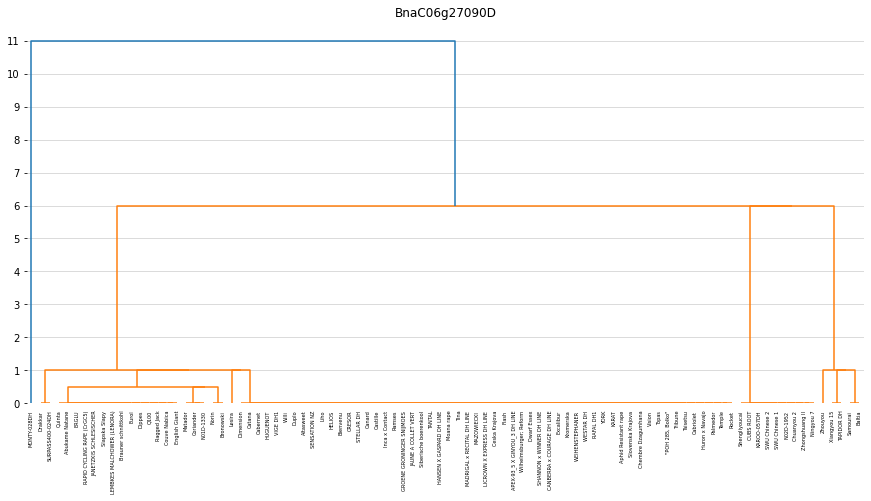

In [1]:
# -*- coding: utf-8 -*-

import numpy as np
from collections import OrderedDict
#import argparse
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import os

GFF_File = '/Users/sidhug/Desktop/Haplotype_project/large_datasets/Brassica_napus.AST_PRJEB5043_v1.44.sorted.gff3'
VCF_FILE = '/Users/sidhug/Desktop/Haplotype_project/large_datasets/raw.g5mac3dplm.recode.vcf'
SAMPLE_NAMES_FILE = '/Users/sidhug/Desktop/Haplotype_project/large_datasets/sample_names.txt'

#GENE_TO_LOOK = ['BnaA02g00370D', 'BnaA03g02820D', 'BnaA03g13630D', 'BnaA10g22080D', 'BnaC02g00490D', 'BnaC03g04170D', 'BnaC03g16530D', 'BnaC09g46500D', 'BnaC09g46540D', 'BnaA02g06490D', 'BnaA04g15260D', 'BnaC04g53290D', 'BnaC04g53290D', 'BnaC04g53290D', 'BnaA05g05010D', 'BnaCnng45490D', 'BnaAnng19140D', 'BnaA03g37880D', 'BnaA03g39820D', 'BnaA06g24000D', 'BnaA04g13710D']
GENE_TO_LOOK = ['BnaC06g27090D'] #FT 

def gff_parse(gff_file, genes_to_look):
    
    Genes = {}
    genes_found = 0
    with open(gff_file, "r") as in_f:
        line = in_f.readline()
        while line:
            line = line.rstrip('\n')
            if line.startswith('#') != True:
                contig = line.split('\t')[0]
                locus_type = line.split('\t')[2]
                if locus_type ==  'gene':
                    gene_name = line.split("\t")[8].split(";")[1].lstrip('Name=')
                    if gene_name in genes_to_look:
                        if contig not in Genes.keys():
                            Genes[contig] = {}
                        (start_pos, stop_pos) = (line.split("\t")[3], line.split("\t")[4])
                        Genes[contig][gene_name] = (start_pos, stop_pos)
                        genes_found += 1
            line = in_f.readline()
    
    return Genes, genes_found


def vcf_parse(vcf_file, Genes):
    # complete_allele_patterns: {SLXXXX:{LKXXXX:{'0001','10101'}, LKXX:..}, SLXX..}
    complete_allele_patterns = {}
    # super_contigs: { LKXXXX: OrderedDict{POS1: (ref, alt), POS2: (ref, alt)..}, LKXXX..}
    #order of posttion values in dict is crucial for this - so LKXXX dicts are all ordered.  
    super_contigs = {}

    with open(vcf_file, 'r') as in_f:
        line = in_f.readline()
        while line:
            line = line.rstrip('\n')
            if line.startswith('#CHROM'):
                samples = line.split('\t')[9:]
                print("Reading the {} file, {} samples found.".format(vcf_file, len(samples)))
                for indv in samples:
                    complete_allele_patterns[indv] = {}
            if line.startswith("#") != True:
                locus = line.split('\t')[0]
                if locus in list(Genes.keys()):
                    super_contigs[locus] = OrderedDict()
                    for indv in complete_allele_patterns.keys():
                        complete_allele_patterns[indv][locus] = ['','']
            line = in_f.readline()

    with open(vcf_file, 'r') as in_f:
        line = in_f.readline()
        while line:
            line = line.rstrip('\n')
            if line.startswith('#') != True:
                line_array = line.split('\t')
                locus = line_array[0]
                position = line_array[1]
                ref = line_array[3]
                alt = line_array[4]
                variant_type = line_array[7].split(';')[-1].lstrip('TYPE=')
                if locus in Genes.keys():
                    super_contigs[locus][position] = (position, variant_type, ref, alt)
                    
                    #for genotype
                    all_samples_genotypes = []
                    for data in line_array[9:]:
                        G = data.split(':')[0]
                        if G == ".":
                            all_samples_genotypes.append("./.")        
                        else:
                            all_samples_genotypes.append(G)
                    
                    assert len(all_samples_genotypes) == len(complete_allele_patterns.keys())
                    for i in range(len(all_samples_genotypes)):
                        
                        complete_allele_patterns[list(complete_allele_patterns.keys())[i]][locus][0] = complete_allele_patterns[list(complete_allele_patterns.keys())[i]][locus][0] + all_samples_genotypes[i].split("/")[0]
                        complete_allele_patterns[list(complete_allele_patterns.keys())[i]][locus][1] = complete_allele_patterns[list(complete_allele_patterns.keys())[i]][locus][1] + all_samples_genotypes[i].split("/")[1]
                        #else:
                        #    print("ERROR in Genotype representation for {}:{} {}".format(locus, position, all_samples_genotypes[i]))
            line = in_f.readline()


    return complete_allele_patterns, super_contigs


def alleles_slicer(start_stop, allele_seqs, positions, gene, locus, sample):
        
    """
        Takes whole contig allele sequences and outputs sliced sequences.
        
        input:
            start_stop: a tuple of ints 
            allele_seqs: a tuple of two alleles patterns. a array/tuple of strings.
            positions: a list of positions for every allele in haplotype sequence.
        
        returns:
            a tupple of sliced allele seqs
    """
    
    try:
        assert len(allele_seqs[0]) == len(positions)
        assert len(allele_seqs[0]) == len(allele_seqs[1])
    except:
        AssertionError
        print("Lengths of position array {} and both allele strings {},{} do not match. {}:{}:{}".format(len(positions),len(allele_seqs[0]), len(allele_seqs[1]), gene,locus,sample))
    pos_array = []
    sliced_allele_0 = ''
    sliced_allele_1 = ''
    for i in range(len(positions)):
        if int(positions[i]) >= int(start_stop[0]) and int(positions[i]) <= int(start_stop[1]):
            pos_array.append(positions[i])
            sliced_allele_0 = sliced_allele_0 + allele_seqs[0][i]    
            sliced_allele_1 = sliced_allele_1 + allele_seqs[1][i]
    
    return (pos_array, [sliced_allele_0, sliced_allele_1])


def final_haplotype_pruning(Genes, complete_allele_patterns ,super_contigs):

    final_data = {}
    for super_locus in super_contigs.keys():
        super_locus_dict = {}
        position_array = list(super_contigs[super_locus].keys())
        for gene in Genes[super_locus].keys():
            current_gene_dict = {}
            start_stop = Genes[super_locus][gene]
            for sample in complete_allele_patterns.keys():
                current_gene_dict[sample] = {} #fill in the innermost dict first
                
                raw_allele_seqs = complete_allele_patterns[sample][super_locus]
                pos_array, sliced_allele_seqs = alleles_slicer(start_stop, raw_allele_seqs, position_array, gene, super_locus, sample)
                
                #marker format : Locus:POS:var_type:Ref allele:alt_allele1,alt_allele2
                marker_array = [super_locus+':'+pos+':'+super_contigs[super_locus][pos][1]+':'+super_contigs[super_locus][pos][2] + ':'+super_contigs[super_locus][pos][3] for pos in pos_array]
                current_gene_dict[sample] = [marker_array, sliced_allele_seqs[0], sliced_allele_seqs[1]]
            final_data[gene] = current_gene_dict

    return final_data


def distance_calculator(seqA_array, seqB_array):
    """
    Return distance between two loci based on two set of allele patterns

    Parameters
    ----------
    seqA_array : List of two strings
        eg. ['101001', '101101']
    seqB_array : List of two strings
        eg. ['101001', '101101']
        

    Returns
    -------
    float
        distance between two samples, averaged. 
        Scoring scheme: +1 if both allele patterns differ
                        +0.5 if only one is different 
                         
    """
    try:
        assert len(seqA_array[0]) == len(seqB_array[0])
        assert len(seqA_array[1]) == len(seqB_array[1])
    except:
        AssertionError
        print("Sequence length mismatch.")
    pattern0 = zip(seqA_array[0], seqB_array[0])
    difference0 = sum([1 for allele in pattern0 if allele[0] != allele[1]])
    pattern1 = zip(seqA_array[1], seqB_array[1])
    difference1 = sum([1 for allele in pattern1 if allele[0] != allele[1]])

    return (difference0 + difference1)/2


def distance_calculator_eu(seqA_array, seqB_array, NA='5'):
    """
    Return distance between two loci based on two set of allele patterns

    Parameters
    ----------
    seqA_array : List of two strings
        eg. ['101001', '101101']
    seqB_array : List of two strings
        eg. ['101001', '101101']
        

    Returns
    -------
    float
        distance between two samples, averaged. 
        Scoring scheme: +1 if both allele patterns differ
                        +0.5 if only one is different 
                         
    """
    try:
        assert len(seqA_array[0]) == len(seqB_array[0])
        assert len(seqA_array[1]) == len(seqB_array[1])
    except:
        AssertionError
        print("Sequence length mismatch.")

    for i, seq in enumerate(seqA_array):
        seqA_array = seq.replace('.', NA)
    for i, seq in enumerate(seqB_array):
        seqB_array = seq.replace('.', NA)

    vectorA_1 = np.array([int(i) for i in seqA_array[0]], dtype=int)
    vectorA_2 = np.array([int(i) for i in seqA_array[1]], dtype=int)

    vectorB_1 = np.array([int(i) for i in seqB_array[0]], dtype=int)
    vectorB_2 = np.array([int(i) for i in seqB_array[1]], dtype=int)
    
    eu_dist_1 = int(np.sqrt(np.sum(np.square(vectorA_1 - vectorB_1))))
    eu_dist_2 = int(np.sqrt(np.sum(np.square(vectorA_2 - vectorB_2))))
    
    return eu_dist_1 + eu_dist_2


def supplementary_output(final_data, gene, sample_names_dict, output_file_name = None):
    if output_file_name == None:
        output_file_name = gene+"_haps.csv"
    else:
        output_file_name = os.path.join(output_file_name, gene+"_haps.csv")
        
    with open(output_file_name, "w") as out_f:
        #first line
        contig_line = " , ," + ','.join([s.split(":")[0] for s in final_data[gene][list(final_data[gene].keys())[0]][0]]) + "\n"
        zeroth_line = "POS, ,"+ ','.join([s.split(":")[1] for s in final_data[gene][list(final_data[gene].keys())[0]][0]]) + "\n"
        first_line = 'TYPE, ,'+ ','.join([s.split(":")[2].replace(',',';') for s in final_data[gene][list(final_data[gene].keys())[0]][0]]) + "\n"
        second_line = 'REF, ,'+ ','.join([s.split(":")[3] for s in final_data[gene][list(final_data[gene].keys())[0]][0]]) + "\n\n"
        out_f.write(contig_line+zeroth_line+first_line+second_line)
        for sample in final_data[gene]:
            haplotype1 = final_data[gene][sample][1]
            haplotype2 = final_data[gene][sample][2]
            seq1 = []
            seq2 = []
            for i in range(len(haplotype1)):
                ref = [final_data[gene][sample][0][i].split(':')[3]]
                alt = final_data[gene][sample][0][i].split(':')[4].split(",")
                ref_alt = ref + alt
                    
                if haplotype1[i] != '.' and haplotype2[i] != '.':
                    seq1.append(ref_alt[int(haplotype1[i])]) if int(haplotype1[i]) != 0 else seq1.append('*')
                    if haplotype1[i] == haplotype2[i]:
                        seq2.append('-')
                    else:
                        seq2.append(ref_alt[int(haplotype2[i])]) if int(haplotype2[i]) != 0 else seq2.append('*')
                        
                else:
                    if haplotype1[i] == '.':
                        seq1.append('.')
                        if haplotype2[i] == '.':
                            seq2.append('.')
                        else:
                            seq2.append(ref_alt[int(haplotype2[i])]) if int(haplotype2[i]) != 0 else seq2.append('*')
                    else:
                        seq1.append(ref_alt[int(haplotype1[i])]) if int(haplotype1[i]) != 0 else seq1.append('*')
                        if haplotype2[i] == '.':
                            seq2.append('.')
                        else:
                            seq2.append(ref_alt[int(haplotype2[i])]) if int(haplotype2[i]) != 0 else seq2.append('*')
            
            sample_line = sample_names_dict[sample]+","+ sample+","+','.join(seq1)+"\n"+' , '+','+','.join(seq2)+"\n\n"
            
            out_f.write(sample_line)        
                    
def create_dendrogram(linkage_matrix, gene, sample_line_names, output_file_name=None):
    
    if output_file_name == None:
        output_file_name = gene+".jpg"
    else:
        output_file_name = os.path.join(output_file_name, gene+".jpg")
        
    
    plt.figure(figsize=(15,7))
    plt.box(False)
    dendrogram(linkage_matrix, labels=sample_line_names)
    plt.yticks(np.arange(0,max(plt.yticks()[0]), 1))                    
    plt.grid(color='lightgrey', which='major', axis='y', linestyle='-')
    plt.title(gene)
    plt.savefig(output_file_name, dpi=300)
    
def output_allele_patterns(final_data, gene, sample_names_dict, output_file_name=None):
    if output_file_name == None:
        output_file_name = gene+"_patterns.txt"
    else:
        output_file_name = os.path.join(output_file_name, gene+"_patterns.txt")

    with open(output_file_name, 'w') as out_f:
        for sample in final_data[gene]:
            haplotype1 = final_data[gene][sample][1]
            haplotype2 = final_data[gene][sample][2]

            to_write = sample_names_dict[sample] + ":" +' '*(30-len(sample_names_dict[sample] + ":")) + final_data[gene][sample][1] +"\n"+ ' '*30+ final_data[gene][sample][2] +"\n" + "\n"
            out_f.write(to_write)
        
    
def main():
    Genes, num_genes_found = gff_parse(GFF_File, GENE_TO_LOOK)
    print("File successfully read, {} out of {} genes found.".format(num_genes_found, len(GENE_TO_LOOK)))
    complete_haplotypes, variant_data = vcf_parse(VCF_FILE, Genes)
    print("Data from VCF file loaded.")
    final_data = final_haplotype_pruning(Genes, complete_haplotypes, variant_data)

    samples = list(final_data[GENE_TO_LOOK[0]].keys())
    with open(SAMPLE_NAMES_FILE, "r") as in_f:
            lines = in_f.readlines()

    sample_names_dict = {}
    for line in lines[1:]:
        sample_names_dict[line.split("\t")[0]] = line.split("\t")[1].replace("\n",'')
    sample_line_names = [sample_names_dict[s] for s in samples]
    
    average_distances_per_sample = np.zeros((len(samples), len(final_data.keys())))
    
    for gene_number, bna_gene in enumerate(final_data.keys()):
        print("Working on {}".format(bna_gene))
        samples = list(final_data[bna_gene].keys())
        
        Distance_Matrix = np.zeros((len(samples), len(samples)))
       
        for vertical in range(Distance_Matrix.shape[0]):
            for horizontal in range(Distance_Matrix.shape[1]):
                Distance_Matrix[vertical][horizontal] = distance_calculator(final_data[bna_gene][samples[vertical]][1:],final_data[bna_gene][samples[horizontal]][1:])
            average_distances_per_sample[vertical][gene_number] = Distance_Matrix[vertical].mean()
            
        dists = squareform(Distance_Matrix)
        linkage_matrix = linkage(dists, 'single')
               
        
        if 'Haplotypes' not in os.listdir():
            os.mkdir('Haplotypes')
        if bna_gene not in os.listdir('Haplotypes'):
            os.mkdir(os.path.join('Haplotypes', bna_gene))
            
        supplementary_output(final_data, bna_gene,sample_names_dict, os.path.join('Haplotypes', bna_gene))
        create_dendrogram(linkage_matrix, bna_gene, sample_line_names, os.path.join('Haplotypes', bna_gene))
        output_allele_patterns(final_data, bna_gene,sample_names_dict, os.path.join('Haplotypes', bna_gene))
        print("Finished gene {}\n".format(bna_gene))
        
    print("All Genes finished. Supplementary data stored.")
    
    
    #input("Program paused. Press any key to continue..")
        
        
        
    return final_data, average_distances_per_sample, samples, sample_line_names

if __name__ == '__main__':
    F, A, samples, S_line_names = main()

In [132]:
import pandas as pd

In [232]:
df = pd.read_csv('/Users/sidhug/Desktop/Haplotype_project/misc/all_rothamsted_combined.csv')
traits = df.columns[3:]
df = df[df['SL_code'].isin(samples)]

In [239]:
list(F.keys())

['BnaA10g22080D',
 'BnaA05g05010D',
 'BnaA03g02820D',
 'BnaC03g04170D',
 'BnaA03g13630D',
 'BnaA02g00370D',
 'BnaA03g37880D',
 'BnaA03g39820D',
 'BnaA06g24000D',
 'BnaA02g06490D',
 'BnaC09g46540D',
 'BnaC09g46500D',
 'BnaC03g16530D',
 'BnaA04g15260D',
 'BnaA04g13710D',
 'BnaC02g00490D',
 'BnaAnng19140D',
 'BnaCnng45490D',
 'BnaC04g53290D']

In [220]:
traits

Index(['ovary_length_adj', 'gynoecia_length_adj', 'style_length_adj',
       'beak_length_adj', 'ovule_area_.cv_adj', 'ovule_number_total_adj',
       'ovule_area_adj', 'seed_weight_10pods_adj', 'pods_plant_adj',
       'pods_main_infl_adj', 'pods_2ary_infl_adj', 'final_height_adj',
       'flowering_branches_adj', 'X2ary_branches_adj', 'X.abortedinfl_adj',
       'X.aborted2ary_adj', 'X.abortedplant_adj', 'flowers_plant_adj',
       'oil_adj', 'X.compact_10pods_adj', 'X.compact_total_adj',
       'X.abortion2ary_average_adj', 'pods_2ary_infl_avg_adj', 'TGW_adj',
       'time_to_flowering_days_adj', 'time_to_maturity_adj',
       'seed_area_10pods_adj', 'seed_area_total_adj', 'seed_area_.cv_adj',
       'seed_weight_total_adj', 'avg_pod_length_adj', 'est_seed_TGW_adj',
       'seed_number_pod_adj', 'VALVE_LENGTH_adj'],
      dtype='object')

In [233]:
trait_arr = df[traits].to_numpy(dtype=np.float32)

In [224]:
trait_arr.shape

(91, 34)

In [226]:
all_Rs = np.zeros((19, 34))

In [234]:
for vertical in range(A.shape[1]):
    for horizontal in range(trait_arr.shape[1]):
        all_Rs[vertical][horizontal], p = pearsonr(A[:, vertical], trait_arr[:, horizontal])
        if p <= 0.1:
            plt.scatter(A.shape[1], trait_arr.shape[1])
            
            
            
            
            
            

In [235]:
all_Rs

array([[ 5.69507636e-02,  1.13970826e-01,  8.65186980e-02,
        -7.81924819e-02, -1.70262057e-02,  7.99881210e-03,
         7.50169127e-02,  2.41562545e-03,  1.09476092e-01,
        -3.43802440e-02,  1.31237457e-01, -5.31508643e-02,
         7.17997926e-02,  7.26577715e-02, -1.06795242e-01,
        -7.86509580e-02, -8.13842294e-02,  1.45941148e-02,
        -1.64356445e-02,  1.55487600e-01,  1.21417702e-01,
        -8.71651866e-02, -4.92675329e-02, -1.95612994e-01,
        -9.05635316e-02, -3.84462924e-02, -1.82287842e-01,
        -1.78849119e-01,  1.34820079e-01,  3.81972647e-02,
        -5.31409002e-03,  1.47041417e-01,  1.05766453e-01,
        -4.41087525e-03],
       [ 4.87337103e-03,  1.92225303e-02,  3.72750504e-03,
         3.58985441e-02,  2.67055269e-02,  1.59148019e-01,
        -2.58955104e-01,  7.15248002e-02,  4.12224088e-02,
        -1.54764253e-01,  8.33435771e-02,  1.29084591e-02,
         1.19065922e-01,  1.21274793e-01,  2.75919313e-02,
        -6.95479934e-02, -4.29

In [237]:
Rs = pd.DataFrame(all_Rs, columns=traits)

In [241]:
Rs['Genes'] = list(F.keys())

In [242]:
Rs = Rs['Genes', 'ovary_length_adj', 'gynoecia_length_adj', 'style_length_adj',
       'beak_length_adj', 'ovule_area_.cv_adj', 'ovule_number_total_adj',
       'ovule_area_adj', 'seed_weight_10pods_adj', 'pods_plant_adj',
       'pods_main_infl_adj', 'pods_2ary_infl_adj', 'final_height_adj',
       'flowering_branches_adj', 'X2ary_branches_adj', 'X.abortedinfl_adj',
       'X.aborted2ary_adj', 'X.abortedplant_adj', 'flowers_plant_adj',
       'oil_adj', 'X.compact_10pods_adj', 'X.compact_total_adj',
       'X.abortion2ary_average_adj', 'pods_2ary_infl_avg_adj', 'TGW_adj',
       'time_to_flowering_days_adj', 'time_to_maturity_adj',
       'seed_area_10pods_adj', 'seed_area_total_adj', 'seed_area_.cv_adj',
       'seed_weight_total_adj', 'avg_pod_length_adj', 'est_seed_TGW_adj',
       'seed_number_pod_adj', 'VALVE_LENGTH_adj']

,ovary_length_adj,gynoecia_length_adj,style_length_adj,beak_length_adj,ovule_area_.cv_adj,ovule_number_total_adj,ovule_area_adj,seed_weight_10pods_adj,pods_plant_adj,pods_main_infl_adj,...,time_to_maturity_adj,seed_area_10pods_adj,seed_area_total_adj,seed_area_.cv_adj,seed_weight_total_adj,avg_pod_length_adj,est_seed_TGW_adj,seed_number_pod_adj,VALVE_LENGTH_adj,Genes
0,0.056951,0.113971,0.086519,-0.078192,-0.017026,0.007999,0.075017,0.002416,0.109476,-0.034380,...,-0.038446,-0.182288,-0.178849,0.134820,0.038197,-0.005314,0.147041,0.105766,-0.004411,BnaA10g22080D
1,0.004873,0.019223,0.003728,0.035899,0.026706,0.159148,-0.258955,0.071525,0.041222,-0.154764,...,-0.189319,-0.158182,-0.172512,-0.074251,-0.041463,0.067883,0.064413,0.217427,0.002762,BnaA05g05010D
2,0.022191,0.039676,0.094772,0.033609,0.064074,-0.106152,-0.009511,-0.335960,-0.128439,-0.105601,...,-0.049008,0.082501,0.104573,0.114695,-0.250750,-0.229397,-0.256477,-0.317741,-0.206236,BnaA03g02820D
3,-0.053163,-0.041803,0.009938,-0.009508,-0.000041,0.007247,0.139624,0.059867,0.002841,-0.071939,...,0.051046,-0.049360,-0.048956,-0.006354,0.069731,0.124781,0.087003,0.091063,0.067830,BnaC03g04170D
4,-0.031032,0.059611,0.120699,-0.009852,-0.154370,0.035499,-0.066728,0.081366,0.137623,-0.062476,...,-0.106719,-0.258398,-0.206952,-0.089957,0.091134,0.128268,0.168979,0.224545,0.084227,BnaA03g13630D
5,-0.147456,-0.090100,-0.007066,0.047392,0.048193,0.096915,-0.113397,0.112754,-0.077618,-0.111448,...,-0.004496,0.025607,0.015162,-0.129970,0.116287,0.066552,0.103197,0.059738,0.002590,BnaA02g00370D
6,0.016317,-0.014395,-0.048659,-0.127482,-0.084847,-0.013433,-0.035669,-0.018227,0.246002,0.160772,...,0.105629,-0.101883,-0.074006,-0.174687,0.183299,-0.042966,0.152592,-0.003256,-0.065817,BnaA03g37880D
7,-0.037898,-0.059950,-0.091859,-0.032186,0.121416,-0.055661,-0.178790,0.073954,-0.063054,-0.152144,...,-0.084377,-0.230558,-0.233339,-0.264359,0.058509,0.079162,0.160112,0.190228,0.055625,BnaA03g39820D
8,0.015300,0.034094,0.031242,0.057640,0.030640,-0.029285,0.024273,-0.041382,-0.242268,-0.189833,...,-0.034633,0.060304,0.089759,0.067505,-0.184023,0.031290,-0.111424,-0.012088,0.024842,BnaA06g24000D
9,0.038356,-0.068163,-0.204551,-0.175526,-0.083412,0.062833,0.060919,0.051564,0.046307,-0.055128,...,0.003110,-0.074896,-0.091018,0.014489,0.088521,-0.001825,0.138675,0.112472,0.010210,BnaA02g06490D


In [244]:
Rs.to_csv("/Users/sidhug/Desktop/Haplotype_project/misc/raw_pearson_rs.csv", index = False)

In [32]:
dist_dict = {}
for i, data in enumerate(A):
    dist_dict[S_line_names[i]] = [float(data)]

In [9]:
S_line_names

['Xiangyou 15',
 'Temple',
 'Rocket',
 'Palmedor',
 'Huron x Navajo',
 'Couve Nabica',
 'Cabriolet',
 'Taisetsu',
 'Tribune',
 '"POH 285, Bolko"',
 'English Giant',
 'Zhongshuang II',
 'Topas',
 'Vision',
 'Ragged Jack',
 'Ningyou 7',
 'Chembre Dzagumhana',
 'Q100',
 'Dippes',
 'Slovenska Krajova',
 'Coriander',
 'Aphid Resistant rape',
 'KARAT',
 'YORK',
 'RAFAL DH1',
 'Eurol',
 'Brauner schnittkohl',
 'WESTAR DH',
 'WEIHENSTEPHANER',
 'Kromerska',
 'Drakkar',
 'Excalibur',
 'CANBERRA x COURAGE DH LINE',
 'Chuanyou 2',
 'SHANNON x WINNER DH LINE',
 'Dwarf Essex',
 'Wilhelmsburger; Reform',
 'N02D-1952',
 'APEX-93_5 X GINYOU_3 DH LINE',
 'LEMBKES MALCHOWER (LENORA)',
 'Flash',
 'SURPASS400-024DH',
 'Samourai',
 'Ceska Krajova',
 'LICROWN X EXPRESS DH LINE',
 'MAZOWIECKI',
 'MADRIGAL x RECITAL DH LINE',
 'Norin',
 'TAPIDOR DH',
 'Slapska Slapy',
 'Tina',
 'Moana rape',
 'HANSEN X GASPARD DH LINE',
 'Baltia',
 'TANTAL',
 'Siberische boerenkool',
 'JAUNE A COLLET VERT',
 'GROENE GRONINGER

In [5]:
tuhh_dict = {}
with open("misc/FLC full dataset h-uh.txt") as in_f:
    for line in in_f:
        if line.split()[0] != 'var!':
            tuhh_dict[line.split()[0].lower()] = float(line.split()[-2])

In [6]:
steve_scores = {}
with open("misc/FLC full dataset h-uh.txt") as in_f:
    for line in in_f:
        if line.split()[0] != 'var!':
            steve_scores[line.split()[0].lower()] = int(line.split()[9])

In [33]:
for key in dist_dict:
    for key2 in tuhh_dict:
        try:
            if key.lower()[:4] == key2[:4]:
                dist_dict[key].append(tuhh_dict[key2])
        except IndexError:
            if key.lower()[:2] == key2[:2]:
                dist_dict[key].append(tuhh_dict[key2])
            
for key in dist_dict:
    for key2 in steve_scores:
        try:
            if key.lower()[:4] == key2[:4]:
                dist_dict[key].append(steve_scores[key2])
        except IndexError:
            if key.lower()[:2] == key2[:2]:
                dist_dict[key].append(steve_scores[key2])            
    

In [11]:
with open("misc/FLC full dataset h-uh.txt") as in_f:
    for line in in_f:
        print(line.split()[9])
        break

FT_C06!


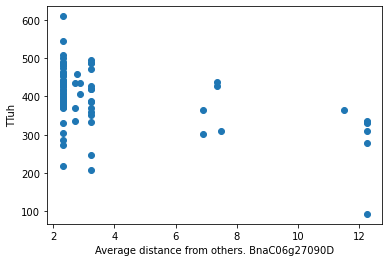

In [12]:
dist = [dist_dict[key][0] for key in dist_dict if len(dist_dict[key]) == 2] 
pheno = [dist_dict[key][1] for key in dist_dict if len(dist_dict[key]) == 2] 


plt.scatter(dist, pheno)
plt.ylabel("TTuh")
plt.xlabel("Average distance from others. BnaC06g27090D")
plt.savefig("BnaC06g27090D.jpg", dpi=300)

In [13]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [14]:
pearsonr(dist, pheno)

(-0.4535879322702702, 1.1548264496872262e-05)

In [15]:
spearmanr(dist, pheno)

SpearmanrResult(correlation=-0.390076812606035, pvalue=0.00020505754551077308)

In [67]:
y = range(len(dist))
m = np.matrix([dist, y]).transpose()

In [68]:
from scipy.cluster.vq import kmeans
kclust = kmeans(m, 3)

In [70]:
kclust[0][:, 0]

array([3.38586957, 3.7201087 , 3.65273613])

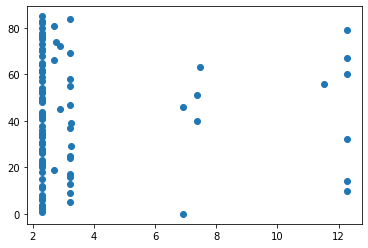

In [71]:
plt.scatter(dist, y)

In [34]:
temp_dict = dist_dict.copy()
for line in temp_dict:
    if len(dist_dict[line]) != 3:
        dist_dict.pop(line)

In [17]:
steve_scores

{'abukame': 3,
 'altasweet': 5,
 'apex-93_5': 1,
 'aphid': 1,
 'baltia': 3,
 'bienvenu': 1,
 'brauner': 3,
 'bronowski': 3,
 'cabernet': 5,
 'cabriolet': 1,
 'canard': 5,
 'canberra': 1,
 'castille': 1,
 'catana': 1,
 'ceska': 2,
 'chembre': 3,
 'chuanyou': 3,
 'coriander': 4,
 'couve': 4,
 'cresor': 1,
 'cubs': 2,
 'dimension': 1,
 'dippes': 4,
 'drakkar': 1,
 'duplo': 1,
 'dwarf': 3,
 'english': 2,
 'erglu': 1,
 'eurol': 3,
 'excalibur': 1,
 'flash': 1,
 'groene': 1,
 'hansen': 1,
 'helios': 1,
 'huguenot': 1,
 'huron': 1,
 'inca': 1,
 'janetzkis': 3,
 'jaune': 2,
 'karat': 1,
 'karoo-057dh': 2,
 'kromerska': 1,
 'lembkes': 1,
 'lesira': 4,
 'licrown': 1,
 'liho': 1,
 'madrigal': 1,
 'matador': 1,
 'mazowiecki': 1,
 'moana': 3,
 'monty-028dh': 6,
 'n01d-1330': 3,
 'ningyou': 2,
 'norin': 4,
 'palmedor': 1,
 'poh': 1,
 'q100': 3,
 'quinta': 3,
 'rafal': 3,
 'ragged': 3,
 'ramses': 1,
 'rocket': 1,
 'samourai': 3,
 'sensation': 2,
 'shannon': 1,
 'shengliyoucai': 2,
 'slapska': 3,
 'sl

In [35]:
with open("misc/comparing_dists_vs_clusts.csv", "w") as out_f:
    for line in dist_dict:
        try:
            out_f.write(line+","+str(dist_dict[line][0])+","+str(dist_dict[line][1])+","+str(dist_dict[line][2])+"\n")
        except IndexError:
            out_f.write(line+","+str(dist_dict[line][0])+","+str(dist_dict[line][1])+"\n")

In [26]:
dist_dict

{'Xiangyou 15': [6.896739130434782, 302.323, 302.323, 302.323, 3],
 'Temple': [2.3043478260869565, 434.028, 434.028, 434.028, 1],
 'Rocket': [2.3043478260869565, 440.873, 440.873, 440.873, 1],
 'Palmedor': [2.3043478260869565, 440.873, 440.873, 440.873, 1],
 'Huron x Navajo': [2.3043478260869565, 388.063, 388.063, 388.063, 1],
 'Couve Nabica': [3.2282608695652173, 248.296, 248.296, 248.296, 4],
 'Cabriolet': [2.3043478260869565, 490.047, 490.047, 490.047, 1],
 'Taisetsu': [2.3043478260869565, 391.965, 391.965, 391.965, 5],
 'Tribune': [2.3043478260869565, 218.462, 218.462, 218.462, 1],
 '"POH 285, Bolko"': [2.3043478260869565],
 'English Giant': [3.2282608695652173, 385.106, 385.106, 385.106, 2],
 'Zhongshuang II': [12.26086956521739, 93.3985, 93.3985, 93.3985, 2],
 'Topas': [2.3043478260869565, 443.711, 443.711, 443.711, 1],
 'Vision': [2.3043478260869565, 409.899, 409.899, 409.899, 1],
 'Ragged Jack': [3.2282608695652173, 419.637, 419.637, 419.637, 3],
 'Ningyou 7': [12.2608695652173

In [36]:
import pandas as pd

In [45]:
data = pd.read_csv("misc/comparing_dists_vs_clusts.csv")
dists = [float(num) for num in data["dist"]]
clusts = [int(num) for num in data["FT_C06"]]
simple_clusts = [int(num) for num in data["FT_C06_simple"]]
pheno = [float(num) for num in data["pheno"]]

In [47]:
from scipy.stats import pearsonr

pheno_dist_r, pheno_dist_p = pearsonr(dists, pheno)
pheno_clust_r, pheno_clust_p = pearsonr(clusts, pheno)
pheno_sclust_r, pheno_sclust_p = pearsonr(simple_clusts, pheno)

In [48]:
print(f"""Analysis Results:\nR value for distances {pheno_dist_r} with p value {pheno_dist_p}\n
R value for clusters {pheno_clust_r} with p value {pheno_clust_p}\n
R value for simple clusters {pheno_sclust_r} with p value {pheno_sclust_p}\n""")

Analysis Results:
R value for distances -0.45358793227785477 with p value 1.1548264492495597e-05

R value for clusters -0.3691063159104103 with p value 0.00047014623781912627

R value for simple clusters -0.0015042586101191226 with p value 0.9890327872679228

